In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb

In [44]:
df = pd.read_csv('cleaned_data.csv')

/var/folders/tw/fk_syw553r14wp3zmby4vhs40000gn/T/ipykernel_18379/1139031434.py:1: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_data.csv')


In [36]:
df.head()

,ID,Language,Original Currency,Purchase Amount (USD),Country,Send Count,Open Count,Click Count,Unique Open Count,Unique Click Count,...,Completion_Rate,Subscription_Start_Date,Subscription_Expiration_Date,Subscription_Duration,Free_Trial_Conversion,Subscription_Renewal,High_Click_Rate,High_Open_Rate,High_Completion_Rate,High_Engagement
11,2142,ESP,EUR,58.2327,Europe,3.0,3.0,1.0,2.0,1.0,...,1.000000e+10,2019-10-24,2020-04-27,186,1,0,1,1,1,1
24,3334,FRA,USD,35.9700,US/Canada,7.0,1.0,0.0,1.0,0.0,...,1.000000e+10,2020-01-02,2020-07-02,182,0,1,0,1,1,1
30,7311,DEU,USD,39.0000,Europe,25.0,0.0,0.0,0.0,0.0,...,1.000000e+10,2019-11-10,2020-02-29,111,0,0,0,0,1,1
31,8149,ITA,USD,119.0000,US/Canada,13.0,6.0,0.0,2.0,0.0,...,1.000000e+10,2019-02-11,2020-08-11,547,0,1,0,1,1,1
39,10619,KOR,USD,32.3700,US/Canada,40.0,2.0,0.0,2.0,0.0,...,1.000000e+10,2018-11-23,2020-04-28,522,1,0,0,0,1,1


In [115]:
df.shape

(460979, 27)

In [45]:
# Handle missing values
from scipy import stats

df = df.dropna(subset=['Purchase Amount (USD)'])

# Fill NA/NaN values with appropriate strategy
#df = df.dropna()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:
        df[column].fillna(df[column].mean(), inplace=True)

# Convert categorical variables to numerical ones
categorical_columns = ['Subscription Type', 'Subscription Event Type', 'Purchase Store', 'Demo User', 'Free Trial User', 'Auto Renew', 'User Type', 'Lead Platform', 'Email Subscriber', 'Push Notifications', 'App Session Platform', 'App Activity Type']
df = pd.get_dummies(df, columns=categorical_columns)

# Convert df columns to numerical representations
date_columns = ['Subscription Start Date', 'Subscription Expiration', 'Free Trial Start Date', 'Free Trial Expiration', 'App Session Date']
for column in date_columns:
    df[column] = pd.to_datetime(df[column])
    df[f"{column}_year"] = df[column].dt.year
    df[f"{column}_month"] = df[column].dt.month
    df[f"{column}_day"] = df[column].dt.day
    df.drop(column, axis=1, inplace=True)

# Feature scaling
# numerical_columns = ['Send Count', 'Open Count', 'Click Count', 'Unique Open Count', 'Unique Click Count']
# scaler = StandardScaler()
# df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# # Outlier detection and removal using IQR method
# Q1 = df[numerical_columns].quantile(0.25)
# Q3 = df[numerical_columns].quantile(0.75)
# IQR = Q3 - Q1
# df = df[~((df[numerical_columns] < (Q1 - 1.5 * IQR)) |(df[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [16]:
df.shape

(180068, 51)

In [37]:
column_dtypes = df.dtypes
# Iterate through column names and data types, and print them
for column_name, dtype in column_dtypes.items():
    print(f"{column_name}: {dtype}")

ID: int64
Language: object
Original Currency: object
Purchase Amount (USD): float64
Country: object
Send Count: float64
Open Count: float64
Click Count: float64
Unique Open Count: float64
Unique Click Count: float64
Subscription Type_Limited: bool
Subscription Event Type_INITIAL_PURCHASE: bool
Subscription Event Type_RENEWAL: bool
Purchase Store_App: bool
Purchase Store_Web: bool
Demo User_No: bool
Demo User_Yes: bool
Free Trial User_No: bool
Free Trial User_Yes: bool
Auto Renew_Off: bool
Auto Renew_On: bool
User Type_Consumer: bool
Lead Platform_App: bool
Lead Platform_Web: bool
Email Subscriber_No: bool
Email Subscriber_Yes: bool
Push Notifications_No: bool
Push Notifications_Yes: bool
App Session Platform_android: bool
App Session Platform_ios: bool
App Session Platform_web: bool
App Activity Type_App Launch: bool
App Activity Type_Completed: bool
App Activity Type_Onboarding: bool
App Activity Type_Other: bool
App Activity Type_Start: bool
Subscription Start Date_year: int32
Subscr

In [46]:
df['Click Count'].fillna(0, inplace=True)
df['Send Count'].fillna(0, inplace=True)

df['App Activity Type_Start'].fillna(0, inplace=True)
df['App Activity Type_Completed'].fillna(0, inplace=True)

df.replace([np.inf, -np.inf], 0, inplace=True)

df['Email_Click_Rate'] = df['Click Count'].astype(int) / (df['Send Count'].astype(int) + 1e-10)
df['Email_Open_Rate'] = df['Open Count'].astype(int) / (df['Send Count'].astype(int) + 1e-10)
df['Completion_Rate'] = df['App Activity Type_Completed'].astype(int) / (df['App Activity Type_Start'].astype(int) + 1e-10)

completion_rate_median = df['Completion_Rate'].median()
df['Completion_Rate'] = df['Completion_Rate'].fillna(completion_rate_median)

df['Subscription_Start_Date'] = pd.to_datetime(df['Subscription Start Date_year'].astype(str) + '-' + df['Subscription Start Date_month'].astype(str) + '-' + df['Subscription Start Date_day'].astype(str))
df['Subscription_Expiration_Date'] = pd.to_datetime(df['Subscription Expiration_year'].astype(str) + '-' + df['Subscription Expiration_month'].astype(str) + '-' + df['Subscription Expiration_day'].astype(str))
df['Subscription_Duration'] = (df['Subscription_Expiration_Date'] - df['Subscription_Start_Date']).dt.days

df['Free_Trial_Conversion'] = np.where((df['Free Trial User_Yes'] == 1) & (df['Subscription Event Type_INITIAL_PURCHASE'] == 1), 1, 0)

df['Subscription_Renewal'] = df['Subscription Event Type_RENEWAL'].astype(int)

click_rate_threshold = df['Email_Click_Rate'].quantile(0.5)
open_rate_threshold = df['Email_Open_Rate'].quantile(0.5)
completion_rate_threshold = df['Completion_Rate'].quantile(0.5)

# Create new binary columns for each rate being above its threshold
df['High_Click_Rate'] = (df['Email_Click_Rate'] > click_rate_threshold).astype(int)
df['High_Open_Rate'] = (df['Email_Open_Rate'] > open_rate_threshold).astype(int)
df['High_Completion_Rate'] = (df['Completion_Rate'] > completion_rate_threshold).astype(int)

# Create 'High_Engagement' if at least two out of the three rates are above their thresholds
df['High_Engagement'] = ((df['High_Click_Rate'] + df['High_Open_Rate'] + df['High_Completion_Rate']) >= 1.5).astype(int)


In [47]:
counts = df['High_Engagement'].value_counts()
percentages = df['High_Engagement'].value_counts(normalize=True)

print(counts)
print(percentages)

High_Engagement
0    161394
1     18674
Name: count, dtype: int64
High_Engagement
0    0.896295
1    0.103705
Name: proportion, dtype: float64


In [48]:
from category_encoders import HashingEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Define features and target
# features = ['Email_Click_Rate', 'Email_Open_Rate', 'Completion_Rate', 'Subscription_Duration', 
#             'Free_Trial_Conversion', 'Subscription Type_Limited',
#             'Subscription Event Type_INITIAL_PURCHASE', 'Subscription Event Type_RENEWAL', 
#             'Demo User_Yes', 'Free Trial User_Yes', 'Auto Renew_On', 'User Type_Consumer',
#             'Email Subscriber_Yes', 'Push Notifications_Yes']

features = ['Subscription_Duration', 
            'Free_Trial_Conversion', 'Subscription Type_Limited',
            'Subscription Event Type_INITIAL_PURCHASE', 'Subscription Event Type_RENEWAL', 
            'Demo User_Yes', 'Free Trial User_Yes', 'Auto Renew_On', 'User Type_Consumer',
            'Email Subscriber_Yes', 'Push Notifications_Yes']


target = 'High_Engagement'

# Split the df into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

In [49]:
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)
xgb_model.fit(X_train, y_train)

feature_importances = xgb_model.feature_importances_

In [50]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Print feature importances
importances = xgb_model.feature_importances_
importance_dict = dict(zip(features, importances))
sorted_importances = sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importances:
    print(f'Feature: {feature}, Importance: {importance}')

Accuracy: 90.88%
Feature: Subscription Event Type_INITIAL_PURCHASE, Importance: 0.1795935332775116
Feature: Free Trial User_Yes, Importance: 0.1680155098438263
Feature: Auto Renew_On, Importance: 0.15137003362178802
Feature: Email Subscriber_Yes, Importance: 0.14591388404369354
Feature: Demo User_Yes, Importance: 0.12511001527309418
Feature: Subscription_Duration, Importance: 0.11778754740953445
Feature: Free_Trial_Conversion, Importance: 0.11220958828926086
Feature: Subscription Type_Limited, Importance: 0.0
Feature: Subscription Event Type_RENEWAL, Importance: 0.0
Feature: User Type_Consumer, Importance: 0.0
Feature: Push Notifications_Yes, Importance: 0.0


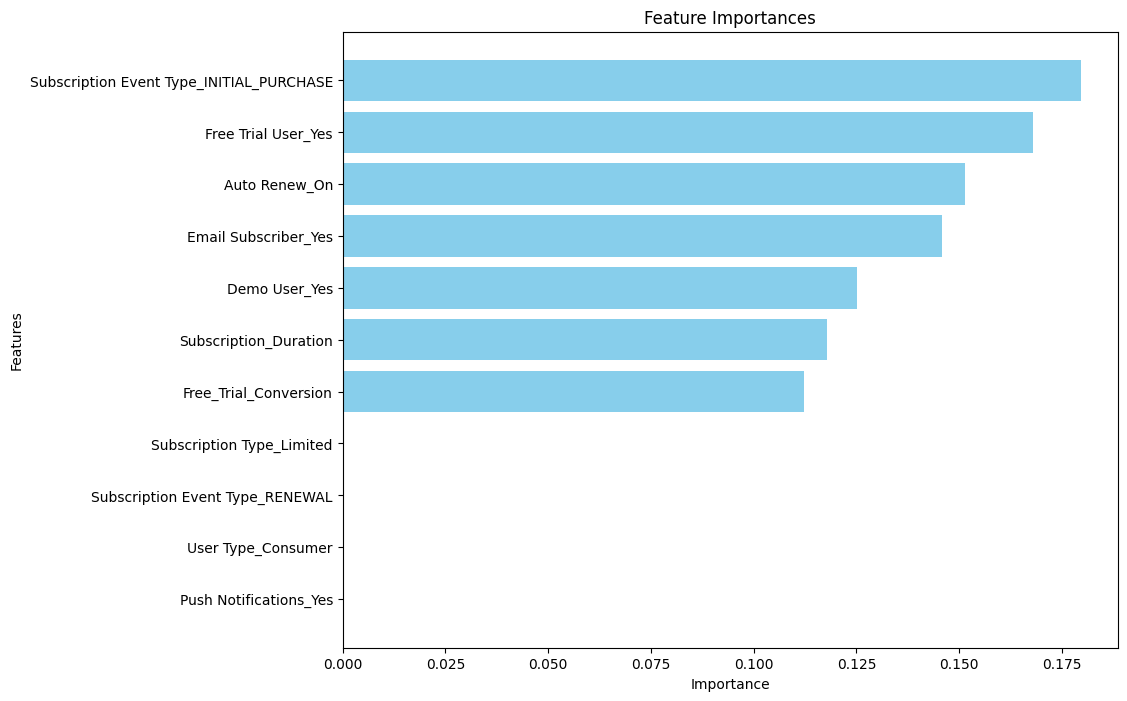

In [52]:

# Extract feature names and their importance
features = [feature for feature, importance in sorted_importances]
importances = [importance for feature, importance in sorted_importances]

# Create a bar chart
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()

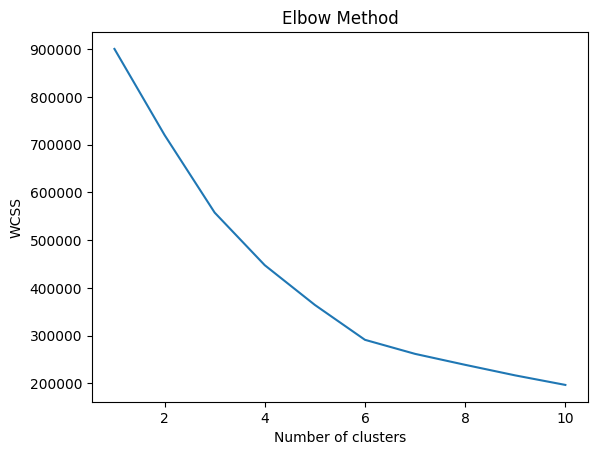

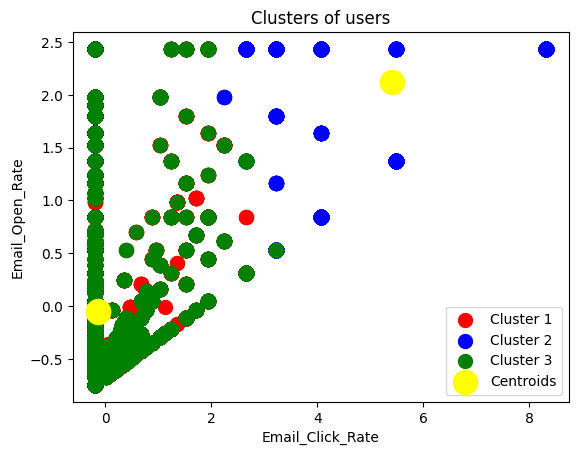

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select columns that will be included in the model
selected_columns = ['Email_Click_Rate', 'Email_Open_Rate', 'Completion_Rate', 'Subscription_Duration', 'Purchase Amount (USD)']

features = df[selected_columns]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features_df = pd.DataFrame(features, index=df.index, columns=selected_columns)

# Determine the optimal number of clusters
# This can be done using the Elbow method, which involves running the algorithm multiple times with different numbers of clusters and looking for an "elbow" in the plot of cost vs. number of clusters.
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_features_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fit the KMeans model with the optimal number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(scaled_features_df)

plt.scatter(scaled_features_df.iloc[pred_y == 0, 0], scaled_features_df.iloc[pred_y == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(scaled_features_df.iloc[pred_y == 1, 0], scaled_features_df.iloc[pred_y == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(scaled_features_df.iloc[pred_y == 2, 0], scaled_features_df.iloc[pred_y == 2, 1], s=100, c='green', label='Cluster 3')

plt.title('Clusters of users')
plt.xlabel(scaled_features_df.columns[0])
plt.ylabel(scaled_features_df.columns[1])
plt.legend()
plt.show()

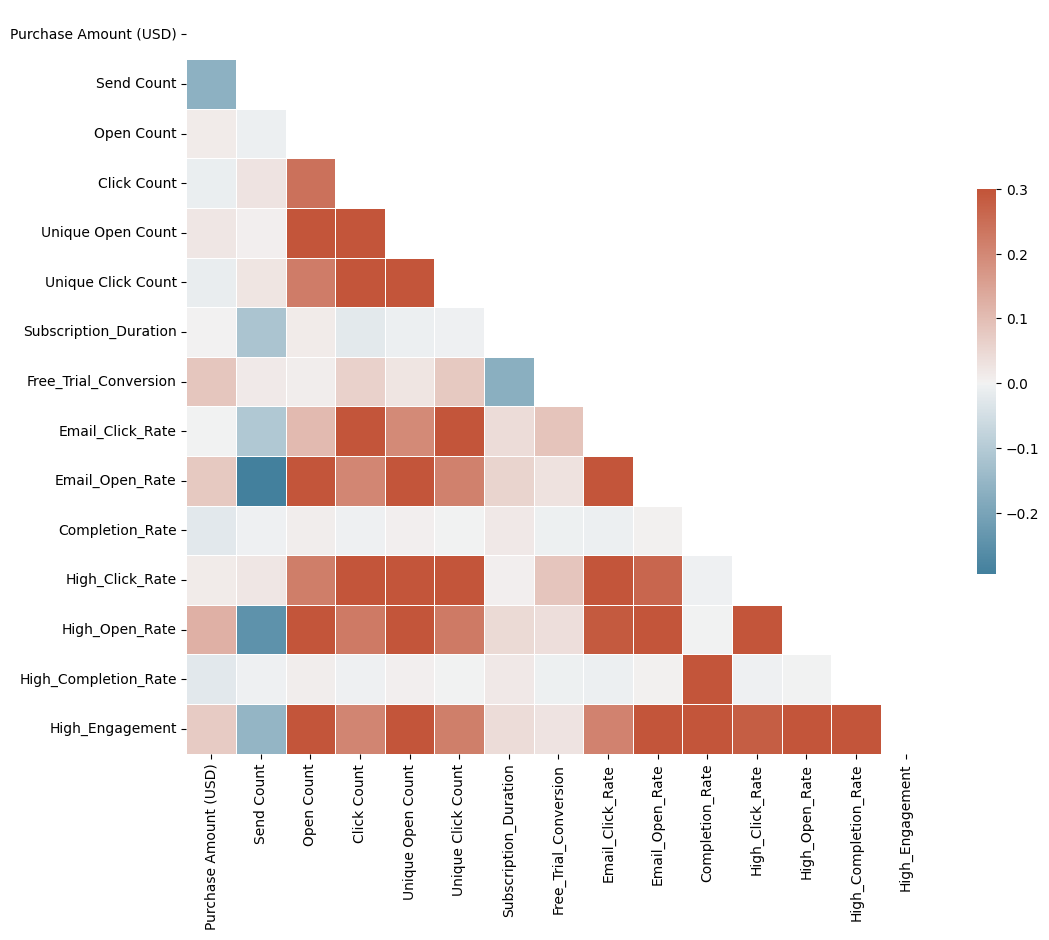

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Relevant columns for the heatmap
heatmap_columns = ['Purchase Amount (USD)', 'Send Count', 'Open Count', 'Click Count', 
                   'Unique Open Count', 'Unique Click Count', 
                   'Subscription_Duration', 'Free_Trial_Conversion', 
                   'Email_Click_Rate', 'Email_Open_Rate', 'Completion_Rate', 
                   'High_Click_Rate', 'High_Open_Rate', 'High_Completion_Rate', 
                   'High_Engagement']

# Compute the correlation matrix
corr_matrix = df[heatmap_columns].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [41]:
print(corr_matrix)


                       Purchase Amount (USD)  Send Count  Open Count   
Purchase Amount (USD)               1.000000   -0.164971    0.013438  \
Send Count                         -0.164971    1.000000   -0.008788   
Open Count                          0.013438   -0.008788    1.000000   
Click Count                        -0.011255    0.027252    0.242961   
Unique Open Count                   0.022526    0.007020    0.840314   
Unique Click Count                 -0.012892    0.024682    0.222930   
Subscription_Duration               0.002357   -0.116538    0.012798   
Free_Trial_Conversion               0.082405    0.016407    0.008127   
Email_Click_Rate                   -0.000093   -0.108611    0.105285   
Email_Open_Rate                     0.077909   -0.294860    0.688262   
Completion_Rate                    -0.023567   -0.003581    0.007563   
High_Click_Rate                     0.012617    0.022865    0.219957   
High_Open_Rate                      0.125053   -0.247842    0.64